In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
#seeding for comparing experiment in part 2
import torch
import json
SEED = 2013
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0')

# SNLI Bert
## Second Tutorial
https://towardsdatascience.com/fine-tuning-pre-trained-transformer-models-for-sentence-entailment-d87caf9ec9db
Check his Github code for complete notebook. I never referred to it. Medium was enough.
BERT in keras-tf: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [70]:
# define macros
BERT_MODEL = 'bert-base-german-cased'
batch_size = 4
batches_per_epoch = 110

save_path_suffix = '20visualizeBertPooler_rand_deu2013_'

# Prepare data

## load the dataset

In [71]:
import pandas as pd

# custom reader needed to handle quotechars
def read_df_custom(file):
    header = 'doc     unit1_toks      unit2_toks      unit1_txt       unit2_txt       s1_toks s2_toks unit1_sent      unit2_sent      dir     nuc_children    sat_children    genre   u1_discontinuous        u2_discontinuous       u1_issent        u2_issent       u1_length       u2_length       length_ratio    u1_speaker      u2_speaker      same_speaker    u1_func u1_pos  u1_depdir       u2_func u2_pos  u2_depdir       doclen  u1_position      u2_position     percent_distance        distance        lex_overlap_words       lex_overlap_length      unit1_case      unit2_case      label'
    extracted_columns = ['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label', 'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case', 'unit2_case',
                            'u1_discontinuous', 'u2_discontinuous', 'same_speaker', 'lex_overlap_length', 'u1_func']
    header = header.split()
    df = pd.DataFrame(columns=extracted_columns)
    file = open(file, 'r')

    rows = []
    count = 0 
    for line in file:
        line = line[:-1].split('\t')
        count+=1
        if count ==1: continue
        row = {}
        for column in extracted_columns:
            index = header.index(column)
            row[column] = line[index]
        rows.append(row)

    df = pd.concat([df, pd.DataFrame.from_records(rows)])
    return df

train_df = read_df_custom('../../processed/deu.rst.pcc_train_enriched.rels')
test_df = read_df_custom('../../processed/deu.rst.pcc_test_enriched.rels')
val_df = read_df_custom('../../processed/deu.rst.pcc_dev_enriched.rels')
lang = 'deu'

## Clean the data

In [72]:
#dropping any empty values
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Prepare a dataset handler class

In [73]:
from collections import Counter


Counter(val_df['distance'])

Counter({'15': 1,
         '1': 142,
         '2': 41,
         '3': 23,
         '5': 9,
         '6': 4,
         '4': 10,
         '7': 3,
         '9': 3,
         '12': 1,
         '14': 1,
         '8': 1,
         '16': 1,
         '10': 1})

In [74]:
train_df.head()

,unit1_txt,unit1_sent,unit2_txt,unit2_sent,dir,label,distance,u1_depdir,u2_depdir,u2_func,...,sat_children,nuc_children,genre,unit1_case,unit2_case,u1_discontinuous,u2_discontinuous,same_speaker,lex_overlap_length,u1_func
0,Dagmar Ziegler sitzt in der Schuldenfalle .,Dagmar Ziegler sitzt in der Schuldenfalle .,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,1>2,interpretation,2,ROOT,ROOT,root,...,0,4,news,cap_initial,other,False,False,True,0,root
1,Auf Grund der dramatischen Kassenlage in Brand...,Auf Grund der dramatischen Kassenlage in Brand...,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,1>2,cause,1,RIGHT,ROOT,root,...,0,4,news,cap_initial,other,False,False,True,0,obl
2,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,Der Rückzieher der Finanzministerin ist aber v...,Der Rückzieher der Finanzministerin ist aber v...,1>2,evaluation-n,4,ROOT,ROOT,root,...,4,3,news,other,cap_initial,False,False,True,0,root
3,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,"und vorgeschlagen , erst 2003 darüber zu entsc...",Auf Grund der dramatischen Kassenlage in Brand...,1<2,conjunction,1,ROOT,LEFT,conj,...,0,4,news,other,other,False,False,True,0,root
4,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,"Überraschend ,","Überraschend , weil das Finanz- und das Bildun...",1<2,interpretation,2,ROOT,ROOT,root,...,1,4,news,other,title,False,False,True,0,root


In [75]:
train_df.columns

Index(['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label',
       'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position',
       'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case',
       'unit2_case', 'u1_discontinuous', 'u2_discontinuous', 'same_speaker',
       'lex_overlap_length', 'u1_func'],
      dtype='object')

# feats

In [76]:
from multiprocessing.sharedctypes import Value
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
from sys import path
path.append('/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/allennlp/data/data_loaders/')
from allennlp.data import allennlp_collate, Vocabulary
from features_custom2 import get_vocab_feature_name
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
import pandas as pd

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df):
    self.lang = lang
    self.num_labels = set()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.train_idx = None
    self.val_idx = None
    self.test_idx = None
    self.vocab = Vocabulary(counter=None, max_vocab_size=100000)
    self.init_data()

  def init_data(self):
    self.get_label_mapping()
    self.init_feature_list()
    self.init_feature_mappings_and_bins()
    self.apply_bins()
    self.calculate_unique_values()
    self.train_data, self.train_idx = self.load_data(self.train_df)
    self.val_data, self.val_idx = self.load_data(self.val_df)
    self.test_data, self.test_idx = self.load_data(self.test_df)
    

  def combine_unique_column_values_to_dict(self, column_name):
    ini_set = set([*self.train_df[column_name].unique(), *self.val_df[column_name].unique()])
    res = dict.fromkeys(ini_set, 0)
    return res

  def get_label_mapping(self):
    labels = {}
    labels_list = list(set(list(self.train_df['label'].unique()) + list(self.test_df['label'].unique()) + list(self.val_df['label'].unique())))
    for i in range(len(labels_list)):
        labels[labels_list[i]] = i
    self.label_dict = labels
    # needed later for classification report object to generate precision and recall on test dataset
    self.rev_label_dict = {self.label_dict[k]:k for k in self.label_dict.keys()} 

  def init_feature_mappings_and_bins(self):
    self.feature_maps = { 'genre': self.combine_unique_column_values_to_dict('genre'),
                          'unit1_case': self.combine_unique_column_values_to_dict('unit1_case'),
                          'unit2_case': self.combine_unique_column_values_to_dict('unit2_case'),
                          'u1_func': self.combine_unique_column_values_to_dict('u1_func'),
                          'u2_func': self.combine_unique_column_values_to_dict('u2_func') }

    self.bins = {
      'distance': [[-1e9, -8], [-8, -2], [-2, 0], [0, 2], [2, 8], [8, 1e9]],
      'u1_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'u2_position': [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0], [1.0, 1e9]],
      'lex_overlap_length': [[0, 2], [2, 7], [7, 1e9]]
    }   

  def add_directionality(self, premise, hypothesis, dir):
    if dir == "1<2":
        hypothesis = '< ' + hypothesis + ' {'
    else:
        premise = '} ' + premise + ' >'
    return premise, hypothesis

  def init_feature_list(self):
    if self.lang=='nld':
      self.feature_list = ['distance', 'u1_depdir', 'sat_children', 'genre', 'u1_position']
    elif self.lang=='deu':
      self.feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
    elif self.lang=='eng.rst.gum':
      self.feature_list = ['distance', 'same_speaker', 'u2_func', 'u2_depdir', 'unit1_case', 'unit2_case', 'nuc_children',
                      'sat_children', 'genre', 'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'u1_position', 'u2_position']
    elif self.lang=='fas':
      self.feature_list = ['distance', 'nuc_children', 'sat_children', 'u2_discontinuous', 'genre']
    elif self.lang=='spa.rst.sctb':
      self.feature_list = ['distance', 'u1_position', 'sat_children']
    elif self.lang=='zho.rst.sctb':
      self.feature_list = ['sat_children', 'nuc_children', 'genre', 'u2_discontinuous', 'u1_discontinuous', 'u1_depdir', 'u1_func']
    else: 
      raise ValueError()

  def get_mapping_from_dictionary(self, column_name, dict_val):
    return self.feature_maps[column_name][dict_val]

  def get_allen_features_list(self, features, feature_name):
    if feature_name in ['distance', 'u1_depdir', 'u2_depdir', 'u1_func', 'u2_func', 
    'u1_position', 'u2_position', 'genre', 'same_speaker', 'unit1_case', 'unit2_case',
    'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'dir']: feature_value = self.apply_vocab(features[feature_name], feature_name) #for categorical values
    elif feature_name in ['sat_children', 'nuc_children']: feature_value = float(features[feature_name]) #for identiy values
    else: 
      print(feature_name)
      raise ValueError()
    return feature_value

  def transform_feature(self, features):
    assert len(features)==17
    #after applying the vocab. we need to pass them as int
    return {feature_name: torch.tensor(int(self.get_allen_features_list(features, feature_name))).to(device) for feature_name in self.feature_list+['dir']}

  def calculate_unique_values(self):
    for feature_name in self.feature_list+['dir']:
      vocab_feature_name = get_vocab_feature_name(feature_name)
      self.vocab.add_tokens_to_namespace(train_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)
      self.vocab.add_tokens_to_namespace(val_df[feature_name].apply(lambda x: str(x)), namespace=vocab_feature_name)

  def apply_bins(self):
    for df in [self.train_df, self.test_df, self.val_df]:
      for feature_name in self.bins.keys():
        df[feature_name] = df[feature_name].apply(lambda x: self.get_mapping_from_bin(feature_name, float(x)))

  def get_mapping_from_bin(self, column_name, dict_val):
    bins = self.bins[column_name]
    for b,i in zip(bins, range(len(bins))):
      left = b[0]
      right = b[1]
      if left<=dict_val and right>=dict_val: return i

  def apply_vocab(self, feature_value, feature_name):
    return self.vocab.get_token_index(str(feature_value), namespace=get_vocab_feature_name(feature_name))

  def set_labels(self):
    self.num_labels = len(self.num_labels)
    
  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []
    feats = []
    idx = []
    idx_map = {}

    self.num_labels.update(df['label'].unique())

    count=0
    for row in df.iterrows():
      row = row[1]
      premise = row['unit1_txt']
      hypothesis = row['unit2_txt']
      label = row['label']
      dir = row['dir']

      features = {'distance': row['distance'],
                'u1_depdir': row['u1_depdir'],
                'u2_depdir': row['u2_depdir'],
                'u1_func': row['u1_func'],
                'u2_func': row['u2_func'],
                'u1_position': row['u1_position'],
                'u2_position': row['u2_position'],
                'sat_children': row['sat_children'],
                'nuc_children': row['nuc_children'],
                'genre': row['genre'],
                'unit1_case': row['unit1_case'],
                'unit2_case': row['unit2_case'],
                'u1_discontinuous': row['u1_discontinuous'],
                'u2_discontinuous': row['u2_discontinuous'],
                'same_speaker': row['same_speaker'],
                'lex_overlap_length': row['lex_overlap_length'],
                'dir': row['dir']}

      premise, hypothesis = self.add_directionality(premise, hypothesis, dir)
      encoded = self.tokenizer.encode_plus(premise, hypothesis, add_special_tokens = True, max_length=MAX_LEN, truncation=True, padding=False) #padding='max_length'
      pair_token_ids = torch.tensor(encoded['input_ids'])

      segment_ids = torch.tensor(encoded['token_type_ids'])
      attention_mask_ids = torch.tensor(encoded['attention_mask'])
      assert len(pair_token_ids)==len(attention_mask_ids)

      features = self.transform_feature(features)

      token_ids.append(pair_token_ids)
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
      feats.append(features)
      
      idx_map[count] = [premise, hypothesis]
      idx.append(count)
      count+=1
      
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    idx = torch.tensor(idx)

    class featureDataset(Dataset):
      def __init__(self, token_ids, mask_ids, seg_ids, feats, y, idx):
          self.token_ids = token_ids
          self.mask_ids = mask_ids
          self.seg_ids = seg_ids
          self.feats = feats
          self.y = y
          self.idx = idx

      def __len__(self):
          return len(self.feats)

      def __getitem__(self, idx):
          return self.token_ids[idx], self.mask_ids[idx], self.seg_ids[idx], self.feats[idx], self.y[idx], self.idx[idx]

    dataset = featureDataset(token_ids, mask_ids, seg_ids, feats, y, idx)
    return dataset, idx_map

  def get_data_loaders(self, batch_size=4, batches_per_epoch=402, shuffle=True): #1609 samples / 64:25=1600 / 402:4=1608
    self.set_labels()
    train_loader_torch = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    val_loader_torch = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    test_loader_torch = DataLoader(
      self.test_data,
      shuffle=False,
      batch_size=batch_size,
    )
    
    train_loader = LoaderWrapper(train_loader_torch, n_step=batches_per_epoch)
    val_loader = LoaderWrapper(val_loader_torch, n_step=batches_per_epoch)
    test_loader = LoaderWrapper(test_loader_torch, n_step=batches_per_epoch)

    return train_loader, val_loader_torch, test_loader_torch

In [77]:
class LoaderWrapper:
    def __init__(self, loader, n_step):
        self.step = n_step
        self.idx = 0
        self.iter_loader = iter(loader)
        self.loader = loader
    
    def __iter__(self):
        return self

    def __len__(self):
        return self.step

    def __next__(self):
        # if reached number of steps desired, stop
        if self.idx == self.step:
            self.idx = 0
            raise StopIteration
        else:
            self.idx += 1
        # while True
        try:
            return next(self.iter_loader)
        except StopIteration:
            # reinstate iter_loader, then continue
            self.iter_loader = iter(self.loader)
            return next(self.iter_loader)

In [78]:
mnli_dataset = MNLIDataBert(train_df, val_df, test_df)

train_loader, val_loader, test_loader = mnli_dataset.get_data_loaders(batch_size=batch_size, batches_per_epoch=batches_per_epoch) #64X250
label_dict = mnli_dataset.label_dict # required by custom func to calculate accuracy, bert model
rev_label_dict = mnli_dataset.rev_label_dict # required by custom func to calculate accuracy

In [79]:
for feature in mnli_dataset.feature_list:
    vocab_feature_name = get_vocab_feature_name(feature)
    print(feature, ': ', mnli_dataset.vocab.get_token_to_index_vocabulary(vocab_feature_name))
print('dir', ': ', mnli_dataset.vocab.get_token_to_index_vocabulary('dir'))


distance :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '3': 2, '4': 3, '5': 4}
u1_depdir :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'RIGHT': 3, 'LEFT': 4}
u2_depdir :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'ROOT': 2, 'RIGHT': 3, 'LEFT': 4}
u2_func :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, 'root': 2, 'conj': 3, 'advcl': 4, 'acl': 5, 'xcomp': 6, 'obl': 7, 'ccomp': 8, 'parataxis': 9, 'advmod': 10, 'dep': 11, 'csubj': 12, 'nmod': 13, 'punct': 14, 'cc': 15, 'appos': 16, 'aux': 17, 'obj': 18, 'iobj': 19, 'nsubj': 20, 'nsubj:pass': 21, 'csubj:pass': 22}
u1_position :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '0': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '1': 11}
u2_position :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '0': 2, '2': 3, '1': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}
sat_children :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '0': 2, '4': 3, '1': 4, '2': 5, '3': 6, '5': 7, '6': 8}
nuc_children :  {'@@PADDING@@': 0, '@@UNKNOWN@@': 1, '4': 2, '3': 3, '1

In [80]:
for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(train_loader):
    # assert pair_token_ids.shape[-1]==512 #torch.Size([4, 512])
    # assert mask_ids.shape[-1]==512
    # assert seg_ids.shape[-1]==512
    assert len(feat)==len(mnli_dataset.feature_list)+1

# Define the model

## load pretrained model

In [81]:
from transformers import BertForSequenceClassification, AdamW
from torch import optim
import os
path.append(os.path.join(os.getcwd(), '../utils/'))
from CategoricalAccuracy import CategoricalAccuracy as CA
import numpy as np

ca = CA()

x = torch.tensor(np.array([[[1,0,0], [1,0,0], [1,0,0]]]))
y1 = torch.tensor(np.array([[0], [1], [1]]))
y2 = torch.tensor(np.array([[0], [0], [0]]))

ca(x,y1)
print(ca.get_metric(reset=True))
ca(x,y2)
print(ca.get_metric(reset=True))

0.3333333333333333
1.0


In [82]:
mnli_dataset.vocab.get_index_to_token_vocabulary('u1_depdir')

{0: '@@PADDING@@', 1: '@@UNKNOWN@@'}

## define evaulation metric

In [83]:
# to evaluate model for train and test. And also use classification report for testing
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# helper function to calculate the batch accuracy
def multi_acc(y_pred, y_test, allennlp=False):
  if allennlp==False:
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

# freeze model weights and measure validation / test 
def evaluate_accuracy(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset.val_idx if is_training else mnli_dataset.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      
      outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      acc = multi_acc(outputs, labels)

      total_val_loss += loss.item()
      total_val_acc  += acc.item()

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        if i not in idx_map.keys():
          print(idx_map)
        premise_list.append(idx_map[i][0])
        hypo_list.append(idx_map[i][1])

  val_acc  = total_val_acc/len(data_loader)
  val_loss = total_val_loss/len(data_loader)
  cr = classification_report(y_true, y_pred)

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}
  
  return val_acc, val_loss, cr, model, optimizer

## define custom bert model

In [84]:
import copy
from typing import Any, Dict, Optional
from transformers import BertModel, AutoTokenizer, BertConfig
from transformers.models.bert.modeling_bert import BertPooler
import torch.nn as nn
from tensorflow.keras.layers import TimeDistributed
from featurefulbertembedder_custom2 import FeaturefulBertEmbedder
from featureful_bert_custom2 import get_combined_feature_tensor_2 as get_combined_feature_tensor_forward
from featureful_bert_custom2 import get_feature_modules
from numpy.linalg import norm


class CustomPooler2(nn.Module):
    def __init__(self, *,
                        requires_grad: bool = True,
                        dropout: float = 0.0,
                        randomize_weights: bool = False,
                        transformer_kwargs: Optional[Dict[str, Any]] = None, ) -> None:
        super().__init__()
        bert = BertModel.from_pretrained(BERT_MODEL) #only used to pass config. BertAttentionClass used in FeatureFulBert
        self._dropout = torch.nn.Dropout(p=dropout)
        self.pooler = copy.deepcopy(bert.pooler)
        if randomize_weights:
            print(self.pooler.dense.weight.shape)
            self.pooler.dense.weight = nn.Parameter(torch.rand(self.pooler.dense.weight.shape))
            self.pooler.dense.bias = nn.Parameter(torch.rand(self.pooler.dense.bias.shape))
            print(self.pooler.dense.weight.shape)
        for param in self.pooler.parameters():
            param.requires_grad = requires_grad
        self._embedding_dim = bert.config.hidden_size

    def get_input_dim(self) -> int:
        return self._embedding_dim

    def get_output_dim(self) -> int:
        return self._embedding_dim

    def forward(self, tokens: torch.Tensor, mask: torch.BoolTensor = None, num_wrapping_dims: int = 0):
        pooler = self.pooler
        
        for _ in range(num_wrapping_dims):
            pooler = TimeDistributed(pooler)
        pooled = pooler(tokens)
        pooled = self._dropout(pooled)
        return pooled

class MyModule(nn.Module):    
    def __init__(self, feature_list, vocab):
        super(MyModule, self).__init__()
        self.feature_list = feature_list
        self.feature_modules, self._feature_module_size = get_feature_modules(feature_list, vocab)

    def forward(self, features):
        return get_combined_feature_tensor_forward(features, self.feature_list, self.feature_modules)

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels, vocab):
          super(CustomBERTModel, self).__init__()
          self.num_classes = num_labels
          self.feature_list = mnli_dataset.feature_list
          print('ASSIGN:', self.num_classes)

          self.embedder = self.create_featureful_bert()
          self.encoder = CustomPooler2()
          self.module1 = MyModule(self.feature_list, vocab)
          self.dropout1 = nn.Dropout(p=0.0)
          self._decoder_input_size = self.encoder._embedding_dim + self.module1._feature_module_size
          self.relation_decoder = nn.Linear(self._decoder_input_size, self.num_classes)

          self.history_w = {
            'cos': [],
            'cos_bert': []
            # 'l1_linear': [],
            # 'l2': []
          }
        #   self.pooler_weight = copy.deepcopy(self.encoder.pooler.dense.weight)
          self.innerpooler_weight = copy.deepcopy(self.embedder.transformer_model.pooler.dense.weight)
          print(self.innerpooler_weight)

    def forward(self, pair_token_ids, token_type_ids, attention_mask, feat):
        direction_tensor = feat['dir'].to(device)
        embedded_sentence = self.embedder(token_ids=pair_token_ids, #featurefulmebedder
                        mask=attention_mask, 
                        type_ids=token_type_ids,
                        segment_concat_mask = None,
                        direction_tensor = direction_tensor,
                        feature_list = self.feature_list,
                        features = feat)
        mask = token_type_ids
        bertpooler_output = self.encoder(tokens=embedded_sentence, mask=mask)
        feat = self.convert_to_feature_list(feat)
        feat = self.dropout1(feat)
        feat = self.module1(feat)
        # print(bertpooler_output.shape, self.module1._feature_module_size, feat.shape)
        try:
            feat_concat = torch.concat((bertpooler_output, feat),-1)
        except:
            print(bertpooler_output.shape, feat.shape)
            raise ValueError()
        assert feat_concat.shape[-1] == self._decoder_input_size
        feat_concat = self.dropout1(feat_concat)
        linear1_output = self.relation_decoder(feat_concat)
        return linear1_output

    def layers_similarities(self):
        # self.compute_pooler_similarity(self.encoder.pooler.dense.weight, self.pooler_weight, 'cos')
        self.compute_pooler_similarity(self.embedder.transformer_model.pooler.dense.weight, self.innerpooler_weight, 'cos_bert')
        # self.pooler_weight = copy.deepcopy(self.encoder.pooler.dense.weight)
        self.innerpooler_weight = copy.deepcopy(self.embedder.transformer_model.pooler.dense.weight)

    def compute_pooler_similarity(self, cur, pre, metric):
        print(metric)
        print(cur)
        print(pre)
        assert torch.all(cur.eq(pre))
        for metric in self.history_w.keys():
            self.history_w[metric].append(self.similarity(cur, pre, metric))

    def similarity(self, cur, pre, metric):
        metric = 0
        n = 0
        for A, B in zip(cur.cpu().detach().numpy(), pre.cpu().detach().numpy()):
            cosine = np.dot(A,B)/(norm(A)*norm(B))
            metric+= cosine
            n+=1
        return float(metric)/float(n), metric

    def create_bert_without_activations(self):
        config = BertConfig.from_pretrained(BERT_MODEL, hidden_act='gelu')
        bert = BertModel.from_pretrained(BERT_MODEL, config=config)
        return bert

    def create_featureful_bert(self):
        featureful_bert = FeaturefulBertEmbedder(model_name = BERT_MODEL,
                                hidden_activation_allen = 'gelu',
                                feature_list = self.feature_list, 
                                vocab=mnli_dataset.vocab)
        return featureful_bert

    def convert_to_feature_list(self, feat):
        feature_linear = [feat[feature_name] for feature_name in self.feature_list]
        feature_linear = torch.stack(feature_linear, dim=-1)
        return feature_linear
        

model = CustomBERTModel(mnli_dataset.num_labels, mnli_dataset.vocab)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, correct_bias=False) # 5e-3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, mode='max', patience=35, min_lr=5e-7, verbose=True) #original factor=0.6, min_lr=5e-7

ASSIGN: 26


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing FeaturefulBert: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing FeaturefulBert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FeaturefulBert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.d

Parameter containing:
tensor([[-0.0415,  0.0087,  0.0124,  ...,  0.0006, -0.0079, -0.0992],
        [ 0.0130,  0.0058,  0.0161,  ..., -0.0027,  0.0095, -0.0131],
        [-0.0177,  0.0175, -0.0046,  ...,  0.0208, -0.0203, -0.0038],
        ...,
        [ 0.0150,  0.0158,  0.0057,  ...,  0.0090, -0.0014,  0.0119],
        [ 0.0873, -0.0189,  0.0052,  ...,  0.0098, -0.0168,  0.0202],
        [ 0.0238,  0.0019, -0.0044,  ...,  0.0067,  0.0224,  0.0113]],
       requires_grad=True)


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## define training regime

### prinintg model

In [85]:
print(model)

CustomBERTModel(
  (embedder): FeaturefulBertEmbedder(
    (transformer_model): FeaturefulBert(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_featur

In [86]:
from torch.utils.tensorboard import SummaryWriter

def writer_init(save_path_suffix):
    writer_path = 'run1/'+save_path_suffix[:-1]+'/'
    if os.path.isdir(writer_path):
        filelist = [ f for f in os.listdir(writer_path) if 'events.out' in f ]
        print(filelist)
        for f in filelist:
            os.remove(os.path.join(writer_path, f))
    else:
        os.mkdir(writer_path)
    writer = SummaryWriter(log_dir=writer_path)
    return writer

writer = writer_init(save_path_suffix)

['events.out.tfevents.1670855540.57e5cab0c4d9.14743.4']


In [87]:
import time
import traceback
import torch.nn.functional as F

from typing import Optional, Iterable, Dict, Any
from EarlyStopperUtil import MetricTracker
from sklearn.metrics import classification_report

EPOCHS = 100


def train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict):  
  EarlyStopper = MetricTracker(patience=12, metric_name='+accuracy')
  best_val_acc = 0


  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    
    # logging for scheduler
    losses = []
    accuracies= []

    train_size = 0

    for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(train_loader):
      train_size+=1
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      feat = feat.to(device)
      outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      loss.backward()
      acc = multi_acc(outputs, labels)
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      losses.append(loss)
      accuracies.append(acc)
      
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    val_acc, val_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, val_loader, rev_label_dict, label_dict, None)
    if val_acc>best_val_acc:
      torch.save(model.state_dict(), save_path_suffix+'_best.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    if val_acc>=best_val_acc:
      torch.save(model.state_dict(), save_path_suffix+'_best_latest.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    EarlyStopper.add_metric(val_acc)
    if EarlyStopper.should_stop_early(): break

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f'train_size: {train_size}')

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_acc', val_acc, epoch)


In [88]:
### MODIFIED
import time
import traceback
import torch.nn.functional as F

from typing import Optional, Iterable, Dict, Any
from EarlyStopperUtil import MetricTracker
from sklearn.metrics import classification_report

EPOCHS = 100


def train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict):  
  EarlyStopper = MetricTracker(patience=12, metric_name='+accuracy')
  best_val_acc = 0


  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    
    # logging for scheduler
    losses = []
    accuracies= []

    train_size = 0

    for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(train_loader):
      train_size+=1
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      # feat = feat.to(device)
      outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      loss.backward()
      acc = multi_acc(outputs, labels)
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      losses.append(loss)
      accuracies.append(acc)
      
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    val_acc, val_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, val_loader, rev_label_dict, label_dict, None)
    if val_acc>best_val_acc:
      torch.save(model.state_dict(), save_path_suffix+'_best.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    if val_acc>=best_val_acc:
      torch.save(model.state_dict(), save_path_suffix+'_best_latest.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    EarlyStopper.add_metric(val_acc)
    if EarlyStopper.should_stop_early(): break

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f'train_size: {train_size}')

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_acc', val_acc, epoch)

    model.layers_similarities()


### train

In [89]:
import warnings
from sklearn.exceptions import DataConversionWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict)

Epoch 1: Best val_acc: 0.0738
Epoch 1: Best val_acc: 0.0738
Epoch 1: train_loss: 4.9563 train_acc: 0.0818 | val_loss: 4.1995 val_acc: 0.0738
00:00:09.42
train_size: 110
cos_bert
Parameter containing:
tensor([[-0.0415,  0.0087,  0.0124,  ...,  0.0006, -0.0079, -0.0992],
        [ 0.0130,  0.0058,  0.0161,  ..., -0.0027,  0.0095, -0.0131],
        [-0.0177,  0.0175, -0.0046,  ...,  0.0208, -0.0203, -0.0038],
        ...,
        [ 0.0150,  0.0158,  0.0057,  ...,  0.0090, -0.0014,  0.0119],
        [ 0.0873, -0.0189,  0.0052,  ...,  0.0098, -0.0168,  0.0202],
        [ 0.0238,  0.0019, -0.0044,  ...,  0.0067,  0.0224,  0.0113]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0415,  0.0087,  0.0124,  ...,  0.0006, -0.0079, -0.0992],
        [ 0.0130,  0.0058,  0.0161,  ..., -0.0027,  0.0095, -0.0131],
        [-0.0177,  0.0175, -0.0046,  ...,  0.0208, -0.0203, -0.0038],
        ...,
        [ 0.0150,  0.0158,  0.0057,  ...,  0.0090, -0.0014,  0.0119],
       

# test

In [90]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0415,  0.0087,  0.0124,  ...,  0.0006, -0.0079, -0.0992],
         [ 0.0130,  0.0058,  0.0161,  ..., -0.0027,  0.0095, -0.0131],
         [-0.0177,  0.0175, -0.0046,  ...,  0.0208, -0.0203, -0.0038],
         ...,
         [ 0.0150,  0.0158,  0.0057,  ...,  0.0090, -0.0014,  0.0119],
         [ 0.0873, -0.0189,  0.0052,  ...,  0.0098, -0.0168,  0.0202],
         [ 0.0238,  0.0019, -0.0044,  ...,  0.0067,  0.0224,  0.0113]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0128,  0.0361,  0.0118,  ..., -0.0349,  0.0027,  0.0091],
         [ 0.0268,  0.1098, -0.0018,  ..., -0.0142,  0.0191, -0.0054],
         [-0.0129, -0.0363, -0.0336,  ..., -0.0324, -0.0478, -0.0155],
         ...,
         [-0.0154,  0.0951,  0.0190,  ...,  0.0050,  0.0081, -0.0168],
         [-0.0018,  0.0676,  0.0259,  ..., -0.0424, -0.0358, -0.0196],
         [-0.0049,  0.0828, -0.0171,  ..., -0.0484,  0.0263, -0.0210]],
        device='cuda:0', r

[1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277]


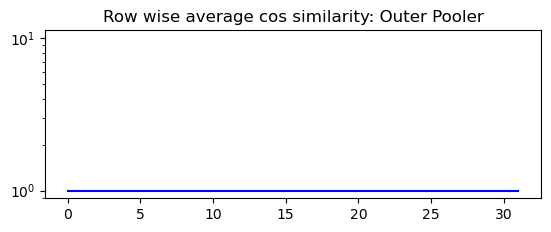

In [91]:
y = model.history_w['cos']
y = [x[0] for x in y]
print(y)

import pylab
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(y, color='blue')
ax.set_yscale('log')
plt.title('Row wise average cos similarity: Outer Pooler')
pylab.show()

[1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277, 1.000000009701277]


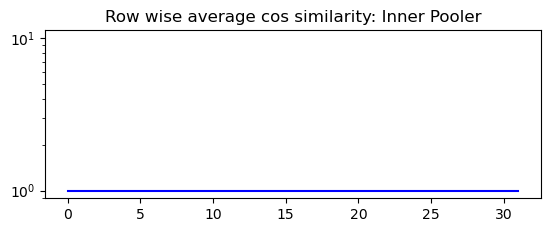

In [92]:
y = model.history_w['cos_bert']
y = [x[0] for x in y]
print(y)

import pylab
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(y, color='blue')
ax.set_yscale('log')
plt.title('Row wise average cos similarity: Inner Pooler')
pylab.show()

In [93]:
for i in model.module1.modules():
    print(i)

MyModule(
  (feature_modules): ModuleDict(
    (distance): Embedding(5, 3, padding_idx=0)
    (u1_depdir): Embedding(5, 3, padding_idx=0)
    (u2_depdir): Embedding(5, 3, padding_idx=0)
    (u2_func): Embedding(23, 5, padding_idx=0)
    (u1_position): Embedding(12, 4, padding_idx=0)
    (u2_position): Embedding(12, 4, padding_idx=0)
    (sat_children): Identity()
    (nuc_children): Identity()
  )
)
ModuleDict(
  (distance): Embedding(5, 3, padding_idx=0)
  (u1_depdir): Embedding(5, 3, padding_idx=0)
  (u2_depdir): Embedding(5, 3, padding_idx=0)
  (u2_func): Embedding(23, 5, padding_idx=0)
  (u1_position): Embedding(12, 4, padding_idx=0)
  (u2_position): Embedding(12, 4, padding_idx=0)
  (sat_children): Identity()
  (nuc_children): Identity()
)
Embedding(5, 3, padding_idx=0)
Embedding(5, 3, padding_idx=0)
Embedding(5, 3, padding_idx=0)
Embedding(23, 5, padding_idx=0)
Embedding(12, 4, padding_idx=0)
Embedding(12, 4, padding_idx=0)
Identity()
Identity()


In [94]:
#latest
def validate(model, test_loader, optimizer, rev_label_dict, label_dict):
  start = time.time()
  test_acc, test_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, test_loader, rev_label_dict, label_dict, is_training=False)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print(cr)

  return test_loss, test_acc


test_loss, test_acc = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_latest', test_loss, 1)
writer.add_scalar('test_acc_latest', test_acc, 1)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 2.7922 test_acc: 0.2000
00:00:00.95
                precision    recall  f1-score   support

    antithesis       0.08      0.22      0.12        18
    background       0.19      0.47      0.27        17
         cause       0.00      0.00      0.00         2
  circumstance       0.17      0.07      0.10        15
    concession       0.00      0.00      0.00        13
     condition       0.43      0.33      0.38         9
   conjunction       0.21      0.43      0.29         7
      contrast       0.13      0.50      0.21         8
 e-elaboration       0.53      0.73      0.62        11
   elaboration       0.00      0.00      0.00        10
  evaluation-n       0.00      0.00      0.00         3
  evaluation-s       0.00      0.00      0.00        17
      evidence       0.00      0.00      0.00        10
interpretation       0.00      0.00      0.00        12
         joint       0.00      0.00      0.00        29
          list       0.33      0.04      0.07        26


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [95]:
#best earliest
model.load_state_dict(torch.load(save_path_suffix+'_best.pt'))
test_loss, test_acc = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 2.9420 test_acc: 0.2269
00:00:00.91
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        18
    background       0.25      0.35      0.29        17
         cause       0.00      0.00      0.00         2
  circumstance       0.20      0.13      0.16        15
    concession       0.08      0.15      0.11        13
     condition       0.18      0.56      0.27         9
   conjunction       0.28      0.71      0.40         7
      contrast       0.00      0.00      0.00         8
   disjunction       0.00      0.00      0.00         0
 e-elaboration       0.57      0.73      0.64        11
   elaboration       0.00      0.00      0.00        10
  evaluation-n       0.00      0.00      0.00         3
  evaluation-s       0.00      0.00      0.00        17
      evidence       0.00      0.00      0.00        10
interpretation       0.11      0.42      0.18        12
         joint       0.33      0.03      0.06        29


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [96]:
#best lastest
model.load_state_dict(torch.load(save_path_suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_best_latest', test_loss, 1)
writer.add_scalar('test_acc_best_latest', test_acc, 1)
print(f'Best Test Loss: {test_loss:.3f} |  Best Test Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 2.9420 test_acc: 0.2269
00:00:01.12
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        18
    background       0.25      0.35      0.29        17
         cause       0.00      0.00      0.00         2
  circumstance       0.20      0.13      0.16        15
    concession       0.08      0.15      0.11        13
     condition       0.18      0.56      0.27         9
   conjunction       0.28      0.71      0.40         7
      contrast       0.00      0.00      0.00         8
   disjunction       0.00      0.00      0.00         0
 e-elaboration       0.57      0.73      0.64        11
   elaboration       0.00      0.00      0.00        10
  evaluation-n       0.00      0.00      0.00         3
  evaluation-s       0.00      0.00      0.00        17
      evidence       0.00      0.00      0.00        10
interpretation       0.11      0.42      0.18        12
         joint       0.33      0.03      0.06        29


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [97]:
#best val acc
model.load_state_dict(torch.load(save_path_suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, val_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')

/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Test_loss: 2.9313 test_acc: 0.2213
00:00:01.04
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        11
    background       0.26      0.53      0.35        17
         cause       0.00      0.00      0.00         7
  circumstance       0.07      0.08      0.07        13
    concession       0.00      0.00      0.00        11
     condition       0.36      1.00      0.53         8
   conjunction       0.27      0.50      0.35         8
      contrast       0.00      0.00      0.00         3
 e-elaboration       0.60      0.69      0.64        13
   elaboration       0.00      0.00      0.00        28
  evaluation-n       0.00      0.00      0.00         8
  evaluation-s       0.00      0.00      0.00         5
      evidence       0.00      0.00      0.00         8
interpretation       0.14      0.31      0.20        13
         joint       0.00      0.00      0.00        18
          list       0.00      0.00      0.00        18


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,